In [1]:
# try:
#   # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import os
import numpy as np
import matplotlib.pyplot as plt

2024-09-07 00:17:15.623206: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 00:17:15.633973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 00:17:15.647405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 00:17:15.651312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 00:17:15.661324: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


I0000 00:00:1725653838.216108   30002 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725653838.251946   30002 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725653838.252119   30002 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [6]:
# # Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 64
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-09-07 00:18:15--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67,43M  4,35MB/s    in 13s     

2024-09-07 00:18:29 (5,29 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
  inflating: cats_and_dogs/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cats_and_dogs/
  inflating: __MACOSX/cats_and_dogs/._.DS_Store  
  inflating: cats_and_dogs/test/48.jpg  
   creating: __MACOSX/cats_and_dogs/test/
  inflating: __MACOSX/cats_and_dogs/test/._48.jpg  
  inflating: cats_and_dogs/test/49.jpg  
  inflating: __MACOSX/cats_and_dogs/test/._49.jpg  
  inflating: cats_and_d

In [7]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255.0)
validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = ImageDataGenerator(rescale=1./255.0)

train_data_gen = train_image_generator.flow_from_directory(train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(test_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode=None, shuffle=False, classes=None)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


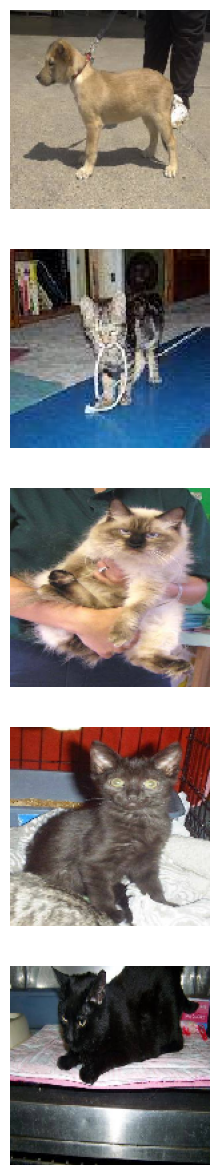

In [8]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [9]:
# 5
train_image_generator = ImageDataGenerator(
                                      rescale=1./255.0,
                                      rotation_range=30,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      brightness_range=[0.8,1.2],
                                      horizontal_flip=True,
                                      fill_mode='nearest',
                                      validation_split=0.2,
                                      )


Found 2000 images belonging to 2 classes.


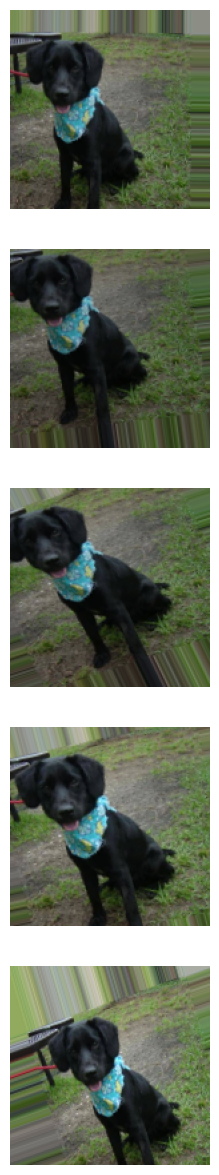

In [10]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [12]:
# 7

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(1,activation="sigmoid"),
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


model.summary()

/home/metaphysicist/Coding/Practice2024/FreeCodeCamp/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1725654249.135534   30002 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725654249.135734   30002 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,678,049 (10.22 MB)

 Trainable params: 2,678,049 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 8
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=epochs,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    validation_steps=int(np.ceil(total_val / float(batch_size))),
    callbacks=[reduce_lr]
    )

Epoch 1/15


/home/metaphysicist/Coding/Practice2024/FreeCodeCamp/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725654260.701918   59651 service.cc:146] XLA service 0x7011e0003bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725654260.701939   59651 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2024-09-07 00:24:20.740446: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-07 00:24:20.958988: I external/local_xla/xla/stream_executor/cuda/cud

 2/32 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5195 - loss: 1.0118 

I0000 00:00:1725654267.895427   59651 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5077 - loss: 0.8426

2024-09-07 00:24:43.880231: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5076 - loss: 0.8397 - val_accuracy: 0.5000 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15


2024-09-07 00:25:01.832702: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 00:25:01.832742: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-07 00:25:01.842612: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-07 00:25:01.842645: I tensorflow/core/framework/local_rendezvous.cc:423] Lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 324ms/step - accuracy: 0.5261 - loss: 0.6883 - val_accuracy: 0.5630 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/15


2024-09-07 00:25:14.491719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469
2024-09-07 00:25:14.491772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11607750695152019403
2024-09-07 00:25:14.497955: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-07 00:25:14.498006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469
2024-09-07 00:25:14.498023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11607750695152019403


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.5069 - loss: 0.6891 - val_accuracy: 0.5450 - val_loss: 0.6705 - learning_rate: 0.0010
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/15


2024-09-07 00:25:27.706455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 365ms/step - accuracy: 0.5701 - loss: 0.6676 - val_accuracy: 0.6210 - val_loss: 0.6497 - learning_rate: 0.0010
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/15


2024-09-07 00:25:41.782547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469
2024-09-07 00:25:41.782584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11607750695152019403
2024-09-07 00:25:41.787095: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-07 00:25:41.787127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469
2024-09-07 00:25:41.787139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11607750695152019403


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step - accuracy: 0.6319 - loss: 0.6545 - val_accuracy: 0.6360 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/15


2024-09-07 00:25:55.289006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469
2024-09-07 00:25:55.289043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11607750695152019403


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.6175 - loss: 0.6399 - val_accuracy: 0.6750 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 12/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 13/15


2024-09-07 00:26:09.100953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469
2024-09-07 00:26:09.100997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11607750695152019403


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 445ms/step - accuracy: 0.6398 - loss: 0.6352 - val_accuracy: 0.6960 - val_loss: 0.5936 - learning_rate: 0.0010
Epoch 14/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 15/15


2024-09-07 00:26:26.059537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6259142911353659469
2024-09-07 00:26:26.059572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11607750695152019403


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 423ms/step - accuracy: 0.6541 - loss: 0.6126 - val_accuracy: 0.6900 - val_loss: 0.5800 - learning_rate: 0.0010


[0.5, 0.5630000233650208, 0.5450000166893005, 0.6209999918937683, 0.6359999775886536, 0.675000011920929, 0.6959999799728394, 0.6899999976158142]


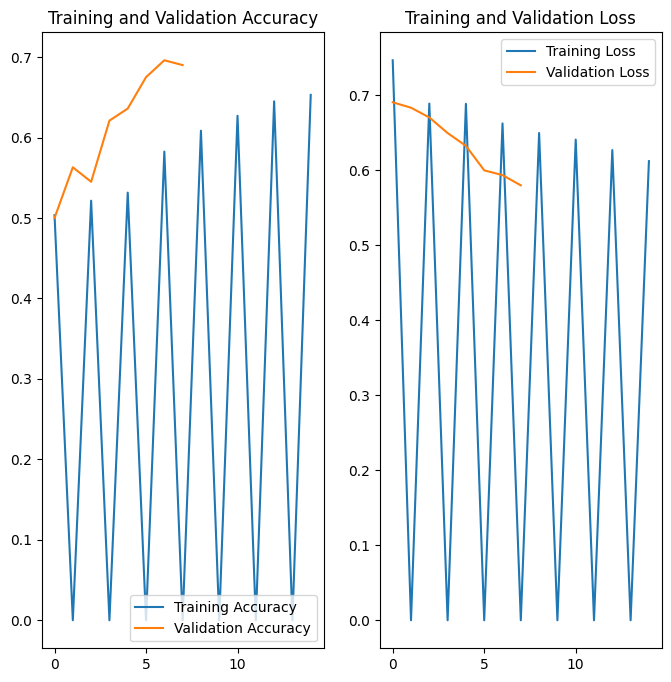

In [20]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
print(val_acc)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range[:len(val_acc)], val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range[:len(val_loss)], val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
probabilities = model.predict(test_data_gen)

/home/metaphysicist/Coding/Practice2024/FreeCodeCamp/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-07 00:31:20.117297: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 419.13MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [22]:
# probabilities = model.predict(test_data_gen).flatten()

print(probabilities.flatten())

[0.48450482 0.51575387 0.10838192 0.5579312  0.6758753  0.6090164
 0.6285355  0.44477305 0.6168116  0.9152306  0.5264393  0.6689835
 0.4479243  0.20292662 0.5398707  0.6337418  0.4002268  0.72432536
 0.5680814  0.6243105  0.17564857 0.50778896 0.3052065  0.3198071
 0.5065202  0.51906174 0.7193722  0.4082598  0.53778327 0.6112386
 0.38826498 0.30254945 0.69677347 0.99995124 0.19032231 0.66607565
 0.99837637 0.6462947  0.46710345 0.41993582 0.59176123 0.46119502
 0.878717   0.44496834 0.44152722 0.4359058  0.5162397  0.36660978
 0.3770965  0.30481517]


In [23]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!


In [24]:
model.save("dog_cat_classifier_model.h5")